# 1. Introduction to the Topic

As part of my PhD, I set out to find out how customer experiences can be personalized along the customer journey. For this, it is particularly relevant to consider customer experiences from different dimensions and ideally to link them. This enables the company to see the customer as a central unit and to offer them an optimized experience at crucial touchpoints. The customer's voice serves as ideal feedback and can be initiated by the company, via surveys, or by the customer, via social media, review websites or customer complaints. However, the underlying data is usually unstrcutred and therefore requires appropriate processing. Especially if this is to be done with the help of automatic algorithms rather than manually through the service employee. Especially due to the high number of customer messages and data, this is preferred nowadays.

For the Data Science Program, I was provided with an SQL file of customer tickets over the last few months. This represents the digital and formalized exchange of information between the company and its customers. In the following script, we will use the provided data to give the company a better insight into its customers. The ovarching general problem is to help companys with their customer support and create better customer experience. To do this, we will first analyze the data to find out what can be done with the data. This will then be used to build a classifier that analyzes incoming customer messages in terms urgency. 

In [1]:
#Required packages
import pandas as pd
from pandas import json_normalize
import json
import re
import numpy as np

import matplotlib.pyplot as plt
from datetime import datetime

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stemmer = SnowballStemmer("german")
stop_words = set(stopwords.words("german"))
from textblob_de import TextBlobDE as TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# 2. Exploratory Analysis of the Data

This chapter aims at investigating and understanding the raw data in order to define the problem

## 2.1 Loading the Dataset

The dataset was exported from the SQL-Database by exporting the table called message to a json file. But as the valuable data was packed inside a cell, it was necessary to normalise it in order to extract the information

In [2]:
df = pd.read_json('message.json')
data = json_normalize(df['data'][2])
data.head(3)

,id,senderid,subject,text,type,seen,issend,isinternal,attachments,ticketid,customerid,channelid,mailserviceid,uid,senddate,modified,issystem
0,2,-3,Ghostwriter Export vom 09.03.2020 15:38,"Hallo,\n\nZeiten für Ticket #vsm1\nZeit am 09....",1,0,0,0,0,0,0,None,None,96a3a007dd5ccc3953f40529a9374a4a,2020-03-09 15:38:01,2020-03-09 15:38:02,1
1,3,-3,Ghostwriter Export vom 09.03.2020 17:02,"Hallo,\n\nZeiten für Ticket #vsm2\nZeit am 09....",1,0,0,0,0,0,0,None,None,ed30ff14cba97f438c9c9e7f9af38708,2020-03-09 17:02:02,2020-03-09 17:02:03,1
2,4,3,",#vsm3,O365: jobs@deinpflegeteam.de anlegen",Hallo Dr. Anno Diekmann.\n\nWir haben Ihr Anli...,1,0,0,0,0,4,4,Ticket:4,None,aacb10ada9f4fe2bbb3ca052524b07b5,2020-03-09 22:00:33,2020-03-09 22:00:33,0


## 2.2 Understanding the Data

Unfortunately, the individual columns and the data they contain are not self-explanatory. Therefore, it is necessary to establish a context with the help of some summaries. <b>

We start by looking at every column and try to understand what it represents. Therefore it is helpful to describe the table:

In [3]:
data.describe()

,id,senderid,subject,text,type,seen,issend,isinternal,attachments,ticketid,customerid,channelid,mailserviceid,uid,senddate,modified,issystem
count,33088,33088,33088,33088,33088,33088,33088,33088,33088,33088,33088,24486,18858,18954,33088,33088,33088
unique,33088,82,4124,13403,6,1,2,2,2,1166,214,1321,10970,10994,12823,17991,2
top,12469,-3,Lesebestätigung: #dt80 Netzwerkprobleme / Zuga...,,1,0,1,0,0,82,1,Ticket:707,AAMkADZmOGY2Njc2LTExMzgtNDk2OS04YjRhLTU4OWQ4MG...,8ba9541729f83666e86942596f23a106,2020-06-10 22:01:00,2020-06-10 22:01:00,1
freq,1,11169,7790,7799,18954,33088,32992,31969,31812,7880,12002,3242,7790,7790,390,195,17853


After some first observations we can observe some information for each column:
1. **id**: Gives every entry in the table a unique id
2. **senderid**: Gives a unique ID to every sender of the ticket. Very likely to be the creater of the ticket, rather than the customer.
3. **subject**: Textual data describing the subject of the message
4. **text**: Textual data including the entire message
5. **type**: Categorial value with 6 unique values, which require further investigation
6. **seen/ issend/ isinternal/ attachments**: Boolean values whether the formulated requirement is fulfilled.
7. **customerid**:  Gives a unique ID to the customer which the ticket is about. The high frequency is interesting and requires further investigation.
8. **ticketid**: Gives a ticket a unique ID - A ticket can have multiple messages. Therefore a ticket describes on complaint.
8. **channelid**:  Somehow a duplication of the ticketid column.
9. **mailserverid**:  Probably gives a unique ID to the used mailservice?
10. **uid**:  Unique id for a user? Might be somehow related to mailserviceid
11. **senddate/ modified**: Containing the date on which the ticket was send or modified.
12. **issystem**: Boolean value whether the ticket is created within the system - so indpendent of a customer? Further investigation needed.

For some of the columns, the high frequency of a unique value are interesting and indicate that the data needs to be cleaned or that there are some very high frequency tickets. For boolean and categorial values though, this seems ok.

#### Investigation of *Type*

As a next step, we investigate the different types of messages by filtering the dataset and describing the statistics, unique values and value counts:

Exemplary we can use the following code:

After investigation we highlight following observations:

Some characteristics from investigating the individual columns:<br>
**Type**<br>
 1: *Nothing found*<br>
 2: Don't have a uid nor a mailserviceid and are only notifications about changes of the status of a ticket <br>
 4: Don't have a uid nor a mailserviceid<br>
 5: Seem to be internal (background) messages, which are not directed towards the customer<br>
 6: All changes without textual data and senderid = -6<br>
 7: Seems to be notifications of a certain type, which is neglectable as it does not contain useful information; the senderid = -6<br>

Based on the information gathered above we can decide to neglect messages of type: 5,6,7

In [4]:
mask_type = (data['type'] == '5')|(data['type'] == '6')|(data['type'] == '7')
newdata = data[~mask_type]

#### Investigation of *Customerid*

Next to the table about messages, the company supplied us with a list of active and inactive customers, which also needs to be loaded from the SQL-File. We filter the dataset so that no inactive customers are included anymore


In [5]:
#Loading the customer data from exported json file
cus = pd.read_json('customer.json')
customer = json_normalize(cus['data'][2])
#Identify inactive customer:
inactive_customers = customer[customer['active']=='0']['id'].to_numpy()
inac = newdata['customerid'].isin(inactive_customers)
#Filter the dataset, so that no inactive customers are included anymore.
newdata = newdata[~inac]

The investigation of the customer data also shows that the cusotmer ID 1 is assigned to the owner - and is therefore used for test purposes. Also the cusotmer ID 0 is not assigned to an exisiting customer.<br>
We exclude all messages with customerid = 1 or 0 

In [6]:
newmask = (newdata['customerid'] == '1')|(newdata['customerid'] == '0')
filtered_data = newdata[~newmask]

#### Investigation of *Subject*

By inspecting the value count of subjects, we can see the high frequency of unique values occurs to a repeated message:

In [7]:
filtered_data['subject'].value_counts()

Lesebestätigung: #dt80 Netzwerkprobleme / Zugangsdaten Panda                 7790
Das Ticket #dt710 hat sich geändert                                           212
Es wurden weitere Information zum Ticket #dt710 hinzugefügt                   211
Unzustellbar: Es wurden weitere Information zum Ticket #dt710 hinzugefügt     186
Das Ticket #dt1147 hat sich geändert                                           29
                                                                             ... 
AW: Ticket #dt1156 E-Mail in der Cloud                                          1
Test2 - Website klar! -                                                         1
Das Ticket #dt16 hat sich geändert                                              1
Ihr Fall wurde aufgenommen, Ticket #dt935                                       1
#dt75 Umstellung Voice over IP Rahl                                             1
Name: subject, Length: 3467, dtype: int64

Hence we clean the table for this message, as it does not contain any information:

In [8]:
subjectmask = filtered_data['subject'] =='Lesebestätigung: #dt80 Netzwerkprobleme / Zugangsdaten Panda'
filtered_data = filtered_data[~subjectmask]

#### Investigation of *Ticketid*

If ticketid is equal 0 this means that there are either background processes or some background data as addresses of individual customers have been changed - hence no ticketid was assigned and no interaction with the customer occurs. The information was observed by following code:

In [9]:
# Hence we filter the data
ticketidmask = filtered_data['ticketid']=='0'
filtered_data = filtered_data[~ticketidmask]

#### Dealing with *Duplication*

For duplications, we check whether a messages information is equal on text, various IDs and the subject. By doing this we control for tickets which are sent twice or three times after each other

In [10]:
dupl = filtered_data.duplicated(['text','customerid','ticketid','channelid','subject'])
filtered_data = filtered_data[~dupl]

In [11]:
filtered_data.describe()

,id,senderid,subject,text,type,seen,issend,isinternal,attachments,ticketid,customerid,channelid,mailserviceid,uid,senddate,modified,issystem
count,6605,6605,6605,6605,6605,6605,6605,6605,6605,6605,6605,6091,3905,3911,6605,6605,6605
unique,6605,81,3311,6425,3,1,2,2,2,842,117,842,3885,3897,2972,4425,2
top,32474,3,Das Ticket #dt710 hat sich geändert,,1,0,1,0,0,713,3,Ticket:713,AAMkADZmOGY2Njc2LTExMzgtNDk2OS04YjRhLTU4OWQ4MG...,b37731eec3334c11197b7c2a9869b408,2020-06-10 22:01:00,2020-06-10 22:01:00,0
freq,1,2066,190,7,3911,6605,6599,5629,5645,382,1867,382,3,2,366,183,3400


## 2.3 First Insights by Conducting Statistical Analysis of the Data

Analysing the efficiency of ticket reponses by reviewing the number of changes per ticket

The average number of changes per ticket is: 2.9689119170984455
But as we can see, the median (2.0) is lower as indicated by the outliner in Ticket 713.




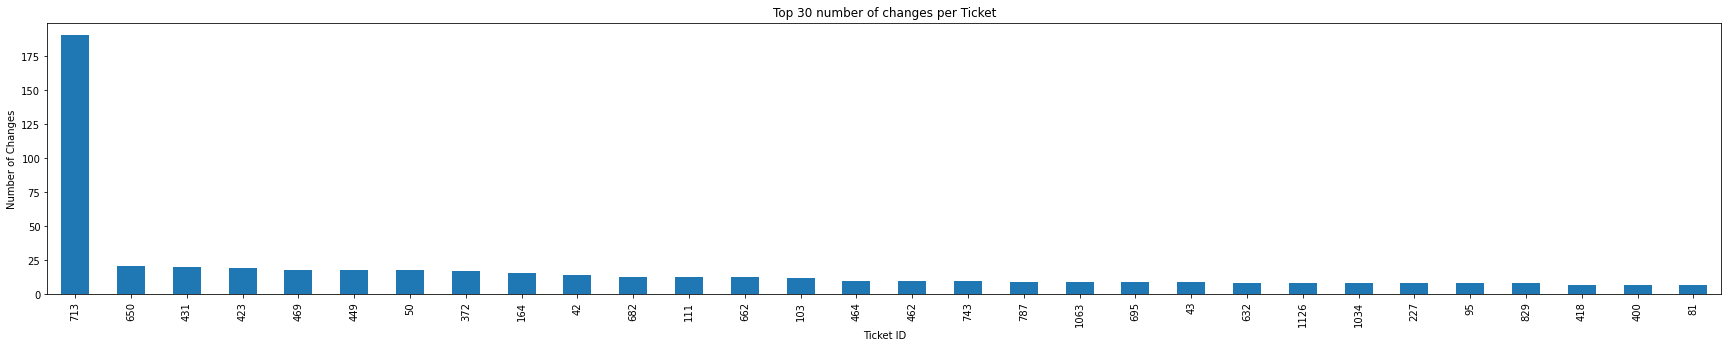

In [12]:
filtered_data[filtered_data['type']=='2']['ticketid'].value_counts().head(30).plot(kind='bar', title = 'Top 30 number of changes per Ticket', xlabel = 'Ticket ID', ylabel = 'Number of Changes', figsize = (30,5));
median = filtered_data[filtered_data['type']=='2']['ticketid'].value_counts().median()
mean = filtered_data[filtered_data['type']=='2']['ticketid'].value_counts().mean()
print(f'The average number of changes per ticket is: {mean}\nBut as we can see, the median ({median}) is lower as indicated by the outliner in Ticket 713.\n\n')

We can also have a look at the customers, which require the most attention due to high frequency of new tickets or changes to existing tickets

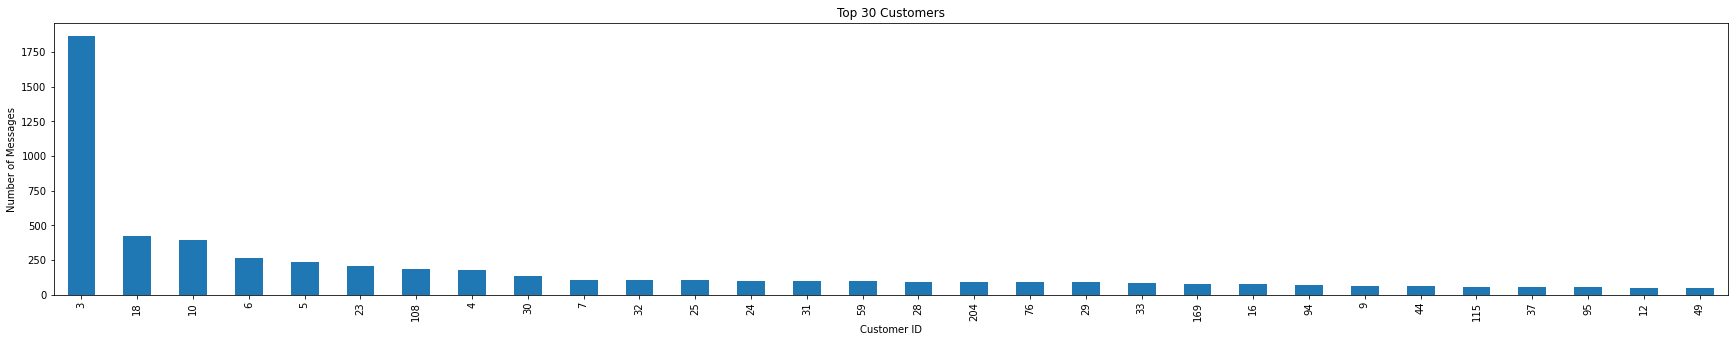

In [13]:
filtered_data['customerid'].value_counts().head(30).plot(kind='bar', title = 'Top 30 Customers', xlabel = 'Customer ID', ylabel = 'Number of Messages', figsize = (30,5));

Graph which shows the number of different tickets per customer

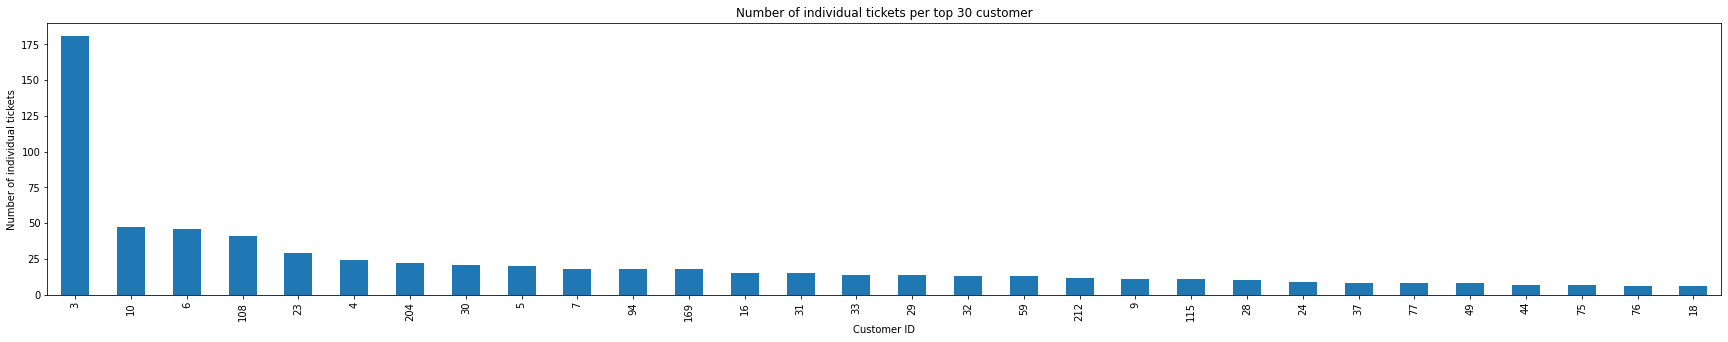

In [14]:
tick_per_cus = filtered_data.groupby('customerid')['ticketid'].nunique().sort_values(ascending = False).head(30)
tick_per_cus.plot.bar(stacked = True, legend = False, title = 'Number of individual tickets per top 30 customer', xlabel = 'Customer ID', ylabel = 'Number of individual tickets', figsize = (30,5));

This shows for example that customer 18 had one very heavy ticket/ problem, whereas customer 10 apperently has a lot of problems occuring over time

As a next step we can conduct some analysis according to the timely development of tickets by plotting their occurrence over time

In [15]:
# Transform the type of data supplied to a useable format
Date = []
month = []
year = []
for i in filtered_data['senddate']:
    Date.append(i.split(' ')[0])
    year.append(i.split('-')[0])
    month.append(i.split('-')[1])
filtered_data['Date'] = Date
filtered_data['Year'] = year
filtered_data['Month'] = month

Now we can plot the Utilization of tickets over the last year

Note We have to consider here that in February 2021 is only the first few days are included 


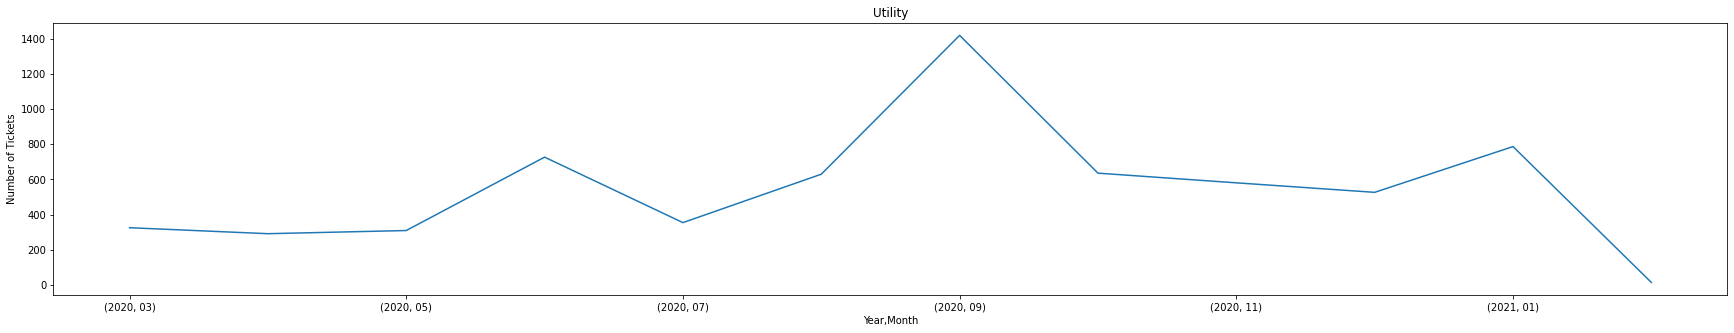

In [16]:
filtered_data.groupby(['Year','Month'])['ticketid'].count().plot(kind = 'line', legend = False, figsize = (30,5),title = 'Utility',ylabel='Number of Tickets');
print('Note We have to consider here that in February 2021 is only the first few days are included ')

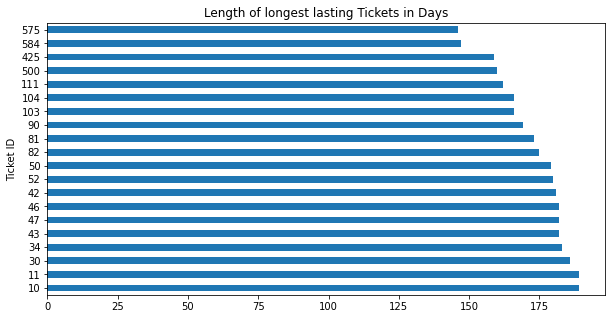

In [17]:
#Calculate the length of a ticket
ticket_unique = filtered_data['ticketid'].unique()
diff = []
for i in ticket_unique:
    fil = filtered_data[filtered_data['ticketid']==i]
    d1 = datetime.strptime(fil['Date'].max(), "%Y-%m-%d")
    d2 = datetime.strptime(fil['Date'].min(), "%Y-%m-%d")
    diff.append(abs((d2 - d1).days))

length_ticket = pd.DataFrame({'ticketid':ticket_unique, 'length':diff})

#Plot the longest and shortest tickets
top_length = length_ticket.sort_values(by='length', ascending = False).head(20)
top_length.set_index('ticketid', inplace = True)
top_length.plot(kind = 'barh', title = 'Length of longest lasting Tickets in Days', xlabel = 'Ticket ID', ylabel = 'Days', figsize = (10,5), legend = False);

To summarise, the above graphs give a first indication of heavily involved customers and tickets. For a company these can serve as a starting point of further analysis to increase the efficiency to solve the customer complaints

# 3 Defining the Problem

**Idea**: Building a prioritisation system for incoming tickets:

We want to predict the severeness of the ticket in order to prioritise them. Therefore, we train a classification system, which allows us to predict urgency of the inocming problem

## 4 Extracting Relevant Information

## 4.1 Identifying Common Problems

By analysing the strucutre of each ticket, we identify, that the problem is displayed in each new ticket (a ticket whose subject contains :'Sie haben eine neues Ticket') and is described after the word: 'Problem'

In [18]:
# We create a DataFrame, which contains all the problem descriptions from the textual data
problem = []

for i in filtered_data[filtered_data['subject'].str.contains(r'Sie haben ein neues Ticket')]['text']:
    if 'Problem' in i:
        total = i.split('Problem',1)[1]
        tot2 = total.split('Hier geht es zum Ticket:')[0] #Because after this phrase no information is stored
        tot3 = tot2.split('liebe Grüße')[0] #After this greeting ususally no information is stored
        problem.append(tot3.split('Mit freundlichen Grüßen')[0]) #After this greeting ususally no information is stored
    else:
        continue
probl = pd.DataFrame(problem, columns = ['Problem Description'])

We can now use the problem description as basis for our classification model.

## 4.2 Extracting Keywords Describing the Problem

**Pre-Processing**

In [19]:
#Clean the text
def clean_text(text, for_embedding=False):

    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    RE_TAGS = re.compile(r"<[^>]+>")
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž ]", re.IGNORECASE)
    RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)
    if for_embedding:
        # Keep punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    text = re.sub(RE_TAGS, " ", text)
    text = re.sub(RE_ASCII, " ", text)
    text = re.sub(RE_SINGLECHAR, " ", text)
    text = re.sub(RE_WSPACE, " ", text)

    word_tokens = word_tokenize(text)
    words_tokens_lower = [word.lower() for word in word_tokens]

    if for_embedding:
        words_filtered = word_tokens
    else:
        words_filtered = [
            word for word in words_tokens_lower if word not in stop_words
        ]
    text_clean = " ".join(words_filtered)
    return text_clean

In [20]:
cleaned_probl = []
for i in probl['Problem Description']:
    clean = clean_text(i)
    cleaned_probl.append(clean) 

**Compute TF-IDF**

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(2,3),smooth_idf=False)
X = vectorizer.fit_transform(cleaned_probl)
word_vector = pd.Series(vectorizer.vocabulary_)

In [22]:
#Filter to the top 10% of the keywords:
top10_num = round(word_vector.shape[0]*0.1)
top10 = word_vector.sort_values(ascending=False).head(top10_num)

**Alternatively we can use the Language Model BERT to extract the keywords**

In [23]:
# As a next step we take the problem description to identify the most common keywords. These can later be used to filter incomming messages
n_gram_range = (2, 4)
stop_words = stopwords.words('german')

# Extract candidate words/phrases
candidates = []
for i in probl['Problem Description']:
    count = CountVectorizer(ngram_range=n_gram_range, stop_words=stop_words).fit([i])
    for n in count.get_feature_names():
        candidates.append(n)
        
# Clean the data for numerical values:
removal_list = []
for i in candidates:
    if bool(re.search(r'\d+', i)):
        removal_list.append(i)
for i in removal_list: candidates.remove(i)

In [24]:
#Using Bert to calculate embeddings for our document and the candidates within the document
#Problem: This embedding takes very long to compute and seems like extreme overengineering
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
doc_embedding = model.encode(probl['Problem Description'].to_list())
candidate_embeddings = model.encode(candidates)

In [25]:
#Define top 1000 keywords
top_n = 50
distances = cosine_similarity(doc_embedding, candidate_embeddings)
keywords = [candidates[index] for index in distances.argsort()[0][-top_n:]]

After now the keywords have been identified, we can see how many of the top keywords are included in one problem description:

In [26]:
#We initiate a DataFrame containing the information
Class_data = pd.DataFrame({'Problem Description':cleaned_probl})

In [27]:
occurrence = []
for n in cleaned_probl:
    num = 0
    for i in top10.index.to_list():
        if i in n:
            num = num+1
        else:
            continue
    occurrence.append(num)
Class_data['occurrence_count'] = occurrence

In [28]:
occurrence_BERT = []
for n in cleaned_probl:
    num = 0
    for i in keywords:
        if i in n:
            num = num+1
        else:
            continue
    occurrence_BERT.append(num)
Class_data['occurrence_BERT'] = occurrence_BERT

### 4.3 Computing the Polarity and Subjectivity of the problem description

In [29]:
polarity = []
subjectivity = []
for i in cleaned_probl:
    polarity.append(TextBlob(i).sentiment.polarity)
    subjectivity.append(TextBlob(i).sentiment.subjectivity)

Class_data['Polarity'] = polarity
Class_data['Subjectivity'] = subjectivity
Class_data = Class_data[Class_data.duplicated(['Problem Description','Polarity', 'Subjectivity'])]

# 5. Building a Classifier

## 5.1 Labelling our Data

Usually, classification models are built based on already labeled data. In this case, however, we have to do the labeling of the data ourselves, since this has not been done by the company. For this we decide ourselves on the variables determined above. These help us to determine the priority of a customer message.

**Variables**<br>
* The lower the polarity the more important the customer message, because dissatisfied customers tend to jump ship. In addition, this is an indicator of urgency <br>
* The higher the subjectivitiy the more important the customer compaint. The more formal language is abandoned, the greater the likelihood that the client needs urgent help because he is desperate.<br>
* The more keywords are contained within the problem description the higher the likelihood that the reported problem is important

In [30]:
def preprocess(column):
    standardscaler = StandardScaler()
    df_copy[column] = standardscaler.fit_transform(df_copy[column].values.reshape(-1, 1))
    
    normscaler = MinMaxScaler()
    df_copy[column]=normscaler.fit_transform(df_copy[column].values.reshape(-1, 1))

In [31]:
df_copy = Class_data
for i in ['Polarity', 'Subjectivity', 'occurrence_count','occurrence_BERT']: preprocess(i)

Now we score the individual columns with a sum function according to our variables:<br>
The signs we use are the following:<br>
* Polarity: *Negative*<br>
* Subjectivity: *Positive*<br>
* Occurrence: *Positive*<br>

We only consider half of the occurence term so it does not weigh out the other variables.

In [32]:
df_copy['Score'] = df_copy['Subjectivity']+df_copy['occurrence_count']*0.5+df_copy['occurrence_BERT']*0.5-df_copy['Polarity']

If we now consider that companies have only limited time, we can use the Pareto principle to allocate time optimally. Similar to the ABC analysis, the problems can be periodized. Thus we assume that the top 20% of the messages in category 1 correspond to approximately 70% of the expenditure, the following 30% further 25% and the last 50% only 5%. This is how we define our groups.<br>
* Group 1: Top 20%<br>
* Group 2: Following 30%<br>
* Group 3: Last 50%<br>

In [33]:
Group = []
for i in df_copy['Score']:
    if i>np.percentile(df_copy['Score'],80):
        group = 1
    elif (i<np.percentile(df_copy['Score'],80))&(i>np.percentile(df_copy['Score'],50)):
        group = 2
    else:
        group = 3
    Group.append(group)
    
df_copy['Priority']=Group

**As a result we now have labeled data**

## 5.2 Training the Classifier

As a first step we split our dataset

In [34]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
train_x, test_x, train_y, test_y = model_selection.train_test_split(df_copy['Problem Description'], df_copy['Priority'], test_size = 0.2)

Now before we use the textual data described in the column Problem Description, we need to transform it into numerical data. There are many different ways out there to embed textual into numerical data. Simple ideas are count-vectors such as One-Hot encoding or TF-IDF, as used earlier. More advanced techniques include pre-trained embeddings such as Word2Vec or GloVe. The most recent approaches contextualise the individual words and use pre-trained language models such as BERT or GPT. For the purpose of this task, we stick to n-grams using word chunks. This is also due to the fact that we cleaned this data before. Therefore most of the work is already done.

In [35]:
# ngram level tf-idf 
ngram = TfidfVectorizer(analyzer='word', ngram_range=(1,3))
ngram.fit(df_copy['Problem Description'])
xtrain_ngram =  ngram.transform(train_x)
xtest_ngram =  ngram.transform(test_x)

As a next step, we are defining a function, which gives us the accuracy of our classifier as an output. This allows us to compare different models

In [36]:
def train_model(classifier, x_train, y_train, x_test):
    # fit the training dataset on the classifier
    classifier.fit(x_train, y_train)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(x_test)
    return metrics.accuracy_score(predictions, test_y)

In [37]:
# Naive Bayes
accuracy_nb = train_model(naive_bayes.MultinomialNB(), xtrain_ngram, train_y, xtest_ngram)
print ("The accuracy of Naive-Bayes Classifier is: ", accuracy_nb)

# Linear Classifier
accuracy_lr = train_model(linear_model.LogisticRegression(), xtrain_ngram, train_y, xtest_ngram)
print ("The accuracy of Logistic Regression Classifier is: : ", accuracy_lr)

# SVM
accuracy_svm = train_model(svm.SVC(), xtrain_ngram, train_y, xtest_ngram)
print ("The accuracy of Support Vector Machine is: ", accuracy_svm)

The accuracy of Naive-Bayes Classifier is:  0.5625
The accuracy of Logistic Regression Classifier is: :  0.5625
The accuracy of Support Vector Machine is:  0.59375


# 6. Closing Remarks

To summarise, we worked on the following aspects in this code:<br>
- First, we loaded the data from the SQL database.
- Then we used various analyses and inspections to understand the data
- This understanding helped us to clean the data and limit it to the necessary information
- In section 2.3, we gained some insights into the data through statistical analysis and were able to give the company some insights into their ticketing system.
- We then addressed the main problem and tried to train a classifier that automatically prioritizes incoming customer messages. <br>

For this step several substeps were necessary. Among other things, we first extracted the text modules that describe the problem using cleaning processes. Based on these problem descriptions, we performed a labeling of the problems. Thus, we determined that a problem is urgent if it contains subjective negative language and contains certain keywords. We were able to determine these using the TF-IDF method as well as the pre-trained Language Model.

Now that we had the prioritized problems, we could use this data to train and ultimately select a classification model. This achieved an accuracy of

In [38]:
print(f'{max(accuracy_svm,accuracy_lr,accuracy_nb)*100}%')

59.375%


------
Future steps in this project could include the following:
- The data is somewhat sparse, so more data would be helpful.
- Our label process is relatively subjective. A non-automatic and thus representative prioritization of problems would be very helpful and increase usability.
- Furthermore, the classification models could be optimized. For example, by changing the coding of text-based data or other models.